Now that we have extracted features from our original dataset, we need to do some Exploratory Data Analysis (EDA) in order to asses the quality of the extracted features and decided we need to perform any of these:
- Feature Scaling
- Feature Transformation
- Feature Engineering

In [1]:
import sys
import os

repository_root_directory = os.path.dirname(os.getcwd())
rrd = "repository_root_directory:\t"
print(rrd, repository_root_directory)

if repository_root_directory not in sys.path:
    sys.path.append(repository_root_directory)
    print(rrd, "added to path")
else:  
    print(rrd, "already in path")

import pandas as pd

repository_root_directory:	 /teamspace/studios/this_studio/csc_461_fp
repository_root_directory:	 added to path


In [2]:
gtzan_features_path = '../_03_data_gtzan_features_labels.xlsx'      # Path to the GTZAN features file
gtzan_features_file = pd.ExcelFile(gtzan_features_path)             # Load the Excel file
gtzan_features_file.sheet_names                                     # See all sheet names               
sheet_data = gtzan_features_file.parse('Sheet1')                    # Load the data from the first sheet
sheet_data.head()                                                   # Display the first few rows: default is 5 rows                     


,RMS,ZCR,Spectral_Centroid,Spectral_Bandwidth,Spectral_Rolloff,Spectral_Contrast_1,Spectral_Contrast_2,Spectral_Contrast_3,Spectral_Contrast_4,Spectral_Contrast_5,...,Mel_Spec_123,Mel_Spec_124,Mel_Spec_125,Mel_Spec_126,Mel_Spec_127,Mel_Spec_128,Energy_Low,Energy_Mid,Energy_High,Genre
0,0.147038,0.083045,1784.158246,2002.506999,3805.806298,16.003262,15.098174,18.453812,18.362476,18.917346,...,0.000544,0.000171,0.000024,2.369133e-06,2.473888e-07,5.895826e-08,16.462635,1.525943,0.064483,0
1,0.140256,0.056040,1530.406302,2039.316747,3550.946767,15.988974,17.059583,19.133453,19.187850,18.326196,...,0.000447,0.000085,0.000011,1.218166e-06,3.065876e-07,2.316311e-07,17.280542,0.825847,0.043837,0
2,0.206913,0.076291,1552.861222,1747.840170,3042.435096,26.330754,14.191844,17.701844,19.419799,20.343111,...,0.000444,0.000110,0.000020,2.538713e-06,3.804544e-07,2.257384e-07,26.967728,5.150474,0.131026,0
3,0.166737,0.033309,1070.285162,1596.858622,2185.012258,29.615439,14.766015,17.238011,18.634724,18.490203,...,0.000128,0.000027,0.000005,4.179691e-07,4.377787e-08,1.586012e-08,27.488083,0.257743,0.013226,0
4,0.106448,0.101461,1835.232440,1748.689585,3580.090700,17.053370,15.693637,19.132733,20.522241,20.784566,...,0.000048,0.000010,0.000002,1.964614e-07,5.799474e-08,4.758992e-08,6.380110,2.516361,0.188032,0


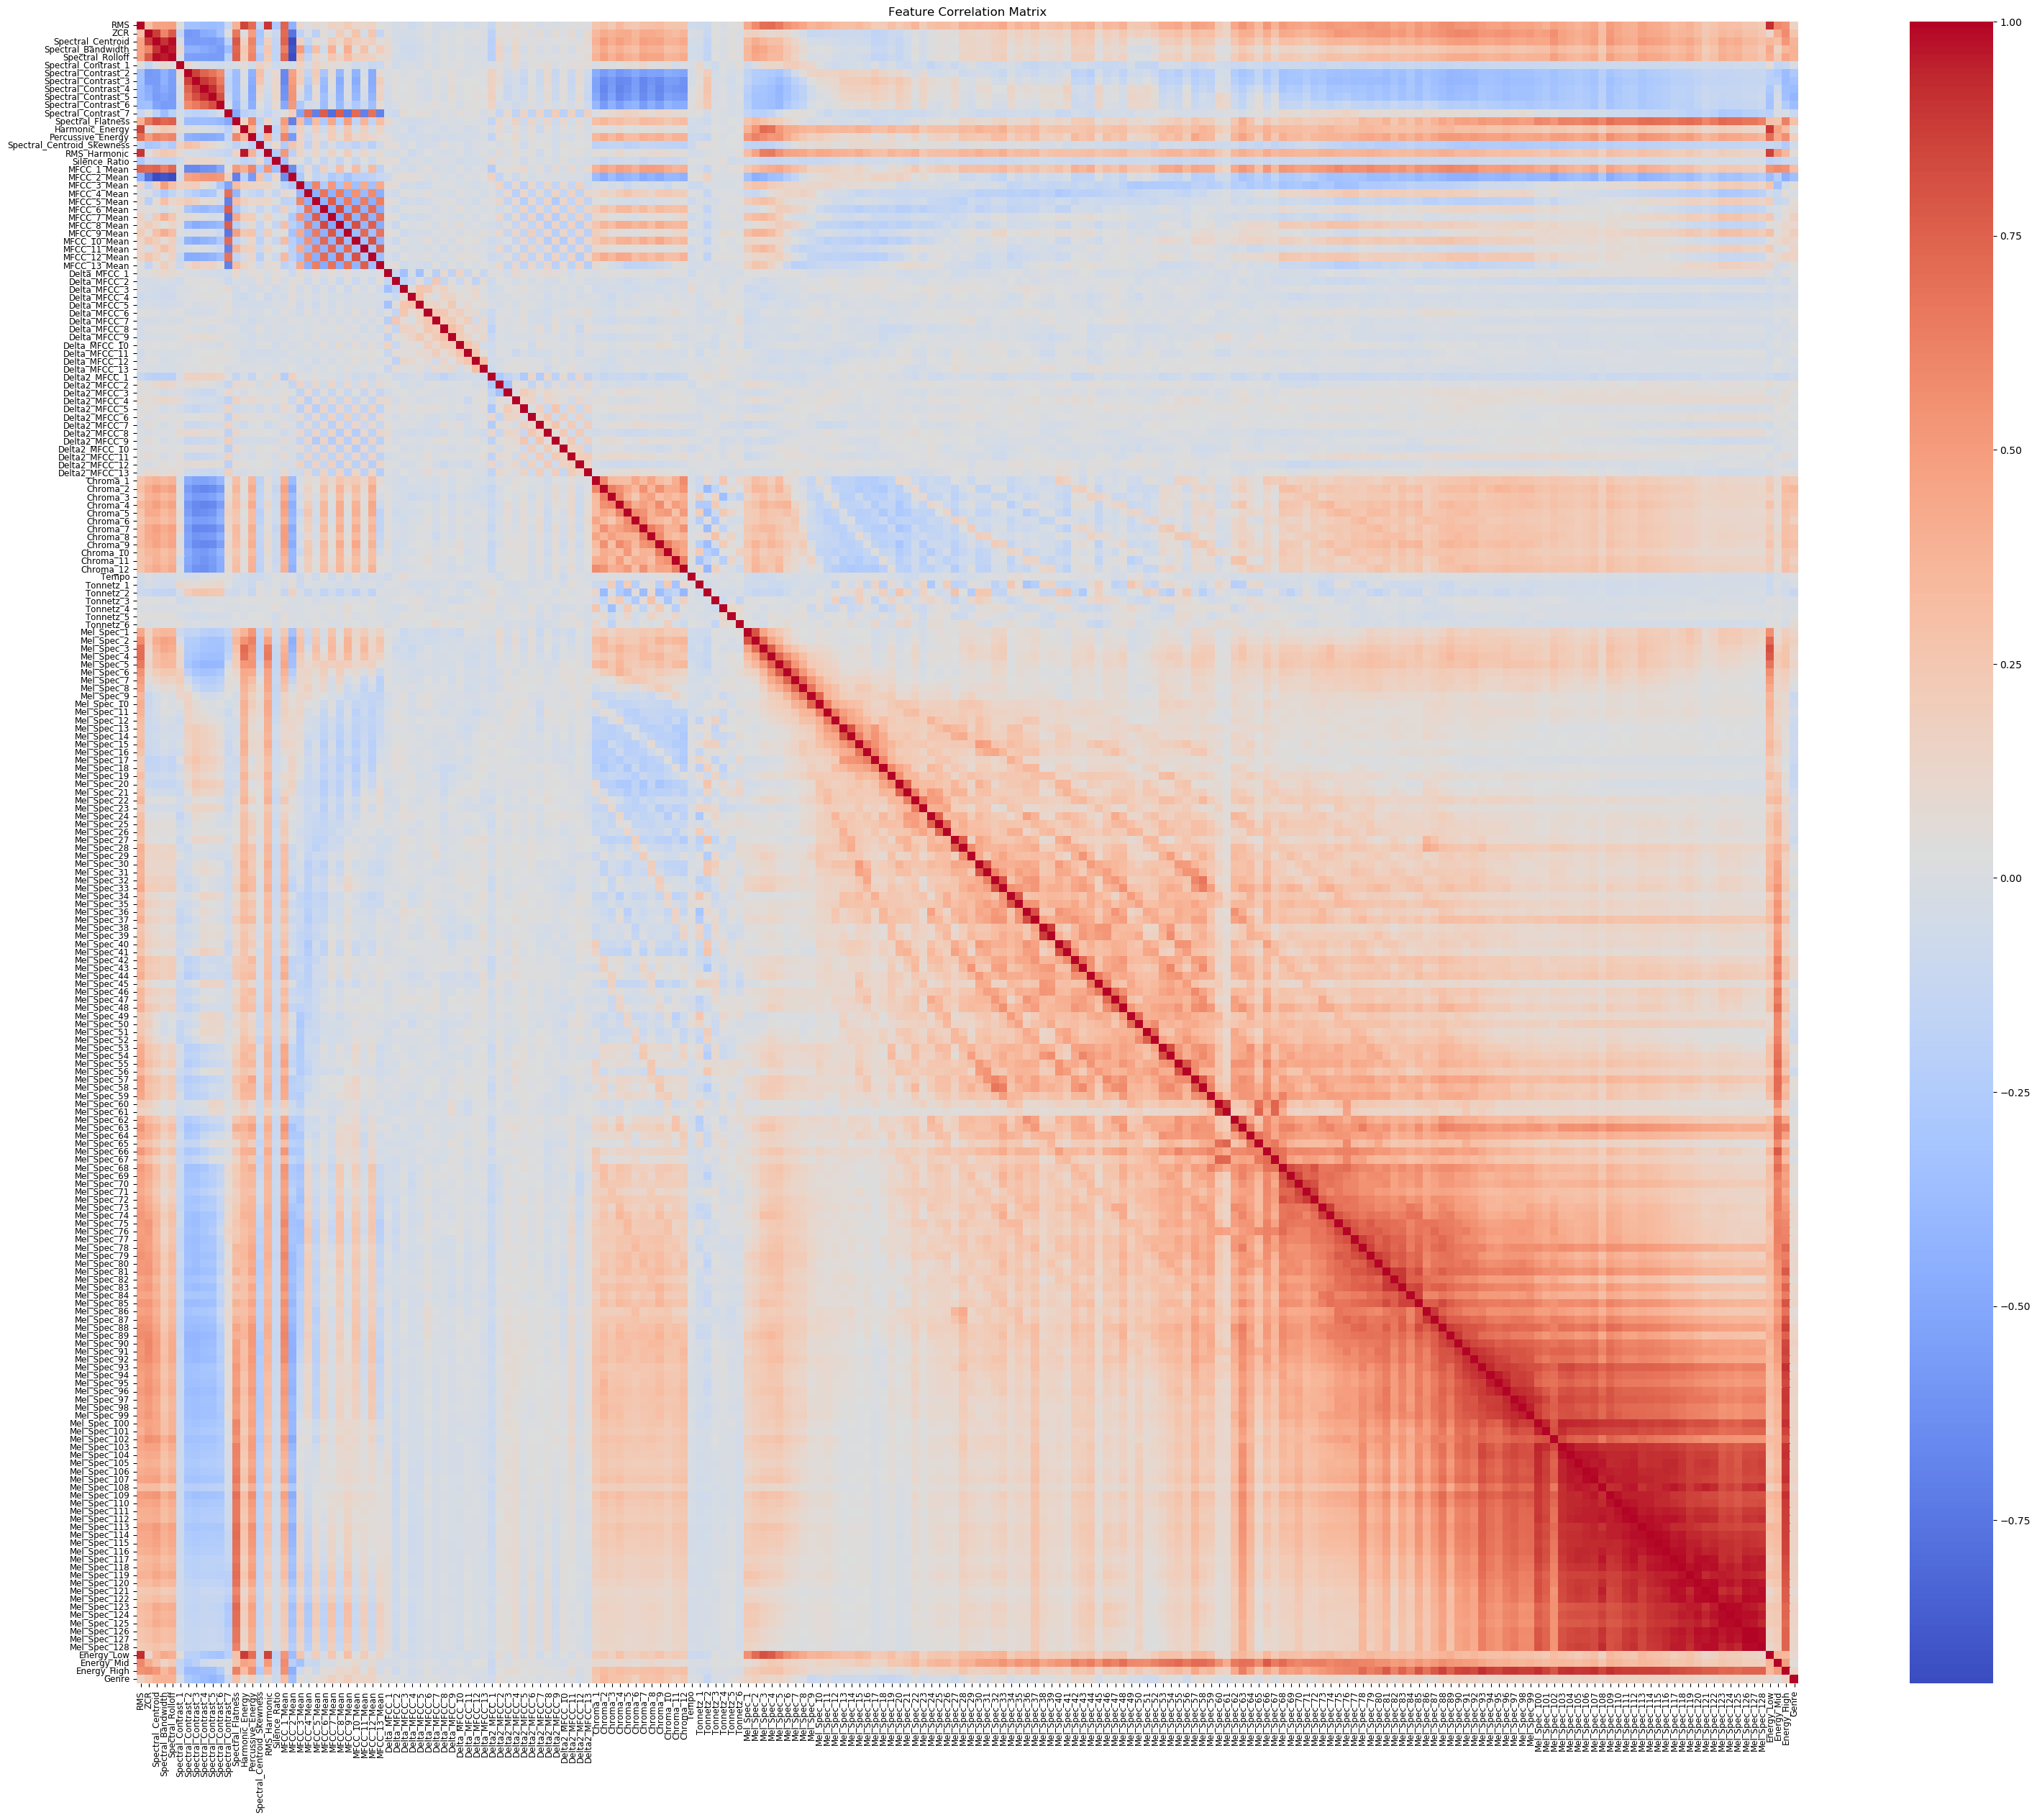

([('RMS', 'Energy_Low'),
  ('Spectral_Centroid', 'Spectral_Bandwidth'),
  ('Spectral_Centroid', 'Spectral_Rolloff'),
  ('Spectral_Centroid', 'MFCC_2_Mean'),
  ('Spectral_Bandwidth', 'Spectral_Centroid'),
  ('Spectral_Bandwidth', 'Spectral_Rolloff'),
  ('Spectral_Rolloff', 'Spectral_Centroid'),
  ('Spectral_Rolloff', 'Spectral_Bandwidth'),
  ('Spectral_Rolloff', 'MFCC_2_Mean'),
  ('Spectral_Contrast_4', 'Spectral_Contrast_5')],
 502)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# # store the genre labels in a separate variable
# genre_labels = sheet_data['Genre']

# Calculate the correlation matrix for feature evaluation
#correlation_matrix = sheet_data.iloc[:, :-1].corr()
correlation_matrix = sheet_data.corr()

# Identify highly correlated features (correlation > 0.9)
high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns 
                   if i != j and abs(correlation_matrix.loc[i, j]) > 0.9]

# Visualize the correlation matrix to understand feature relationships
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, square=True, annot=False, 
            xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
plt.xticks(rotation=90, fontsize=8.5)
plt.yticks(fontsize=8.5)
plt.title('Feature Correlation Matrix')
# add the index of the features to the x and y axis
plt.show()

# Display summary of highly correlated features
high_corr_pairs[:10], len(high_corr_pairs)  # Display the first 10 pairs and total count of highly correlated features


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Extract the Mel_Spec_* features for PCA
mel_spec_features = [col for col in sheet_data.columns if 'Mel_Spec_' in col]
mel_spec_data = sheet_data[mel_spec_features]

# Standardize the data before PCA
scaler = StandardScaler()
mel_spec_data_scaled = scaler.fit_transform(mel_spec_data)

# Apply PCA and retain components that explain ~95% of the variance
pca = PCA(n_components=0.98, random_state=42)
mel_spec_pca = pca.fit_transform(mel_spec_data_scaled)

# Create a DataFrame for the PCA-transformed features
mel_spec_pca_df = pd.DataFrame(
    mel_spec_pca, columns=[f'PCA_Mel_Spec_{i+1}' for i in range(mel_spec_pca.shape[1])]
)

# Combine the PCA-transformed features with the rest of the dataset
non_mel_spec_features = sheet_data.drop(columns=mel_spec_features)
df_final = pd.concat([non_mel_spec_features, mel_spec_pca_df], axis=1)

# move the genre column to the end of the dataset
genre = df_final.pop('Genre')
df_final['Genre'] = genre


# Display updated dataset information
df_final.info()

# print the shape of the dataset
df_final.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 147 entries, RMS to Genre
dtypes: float64(146), int64(1)
memory usage: 1.1 MB


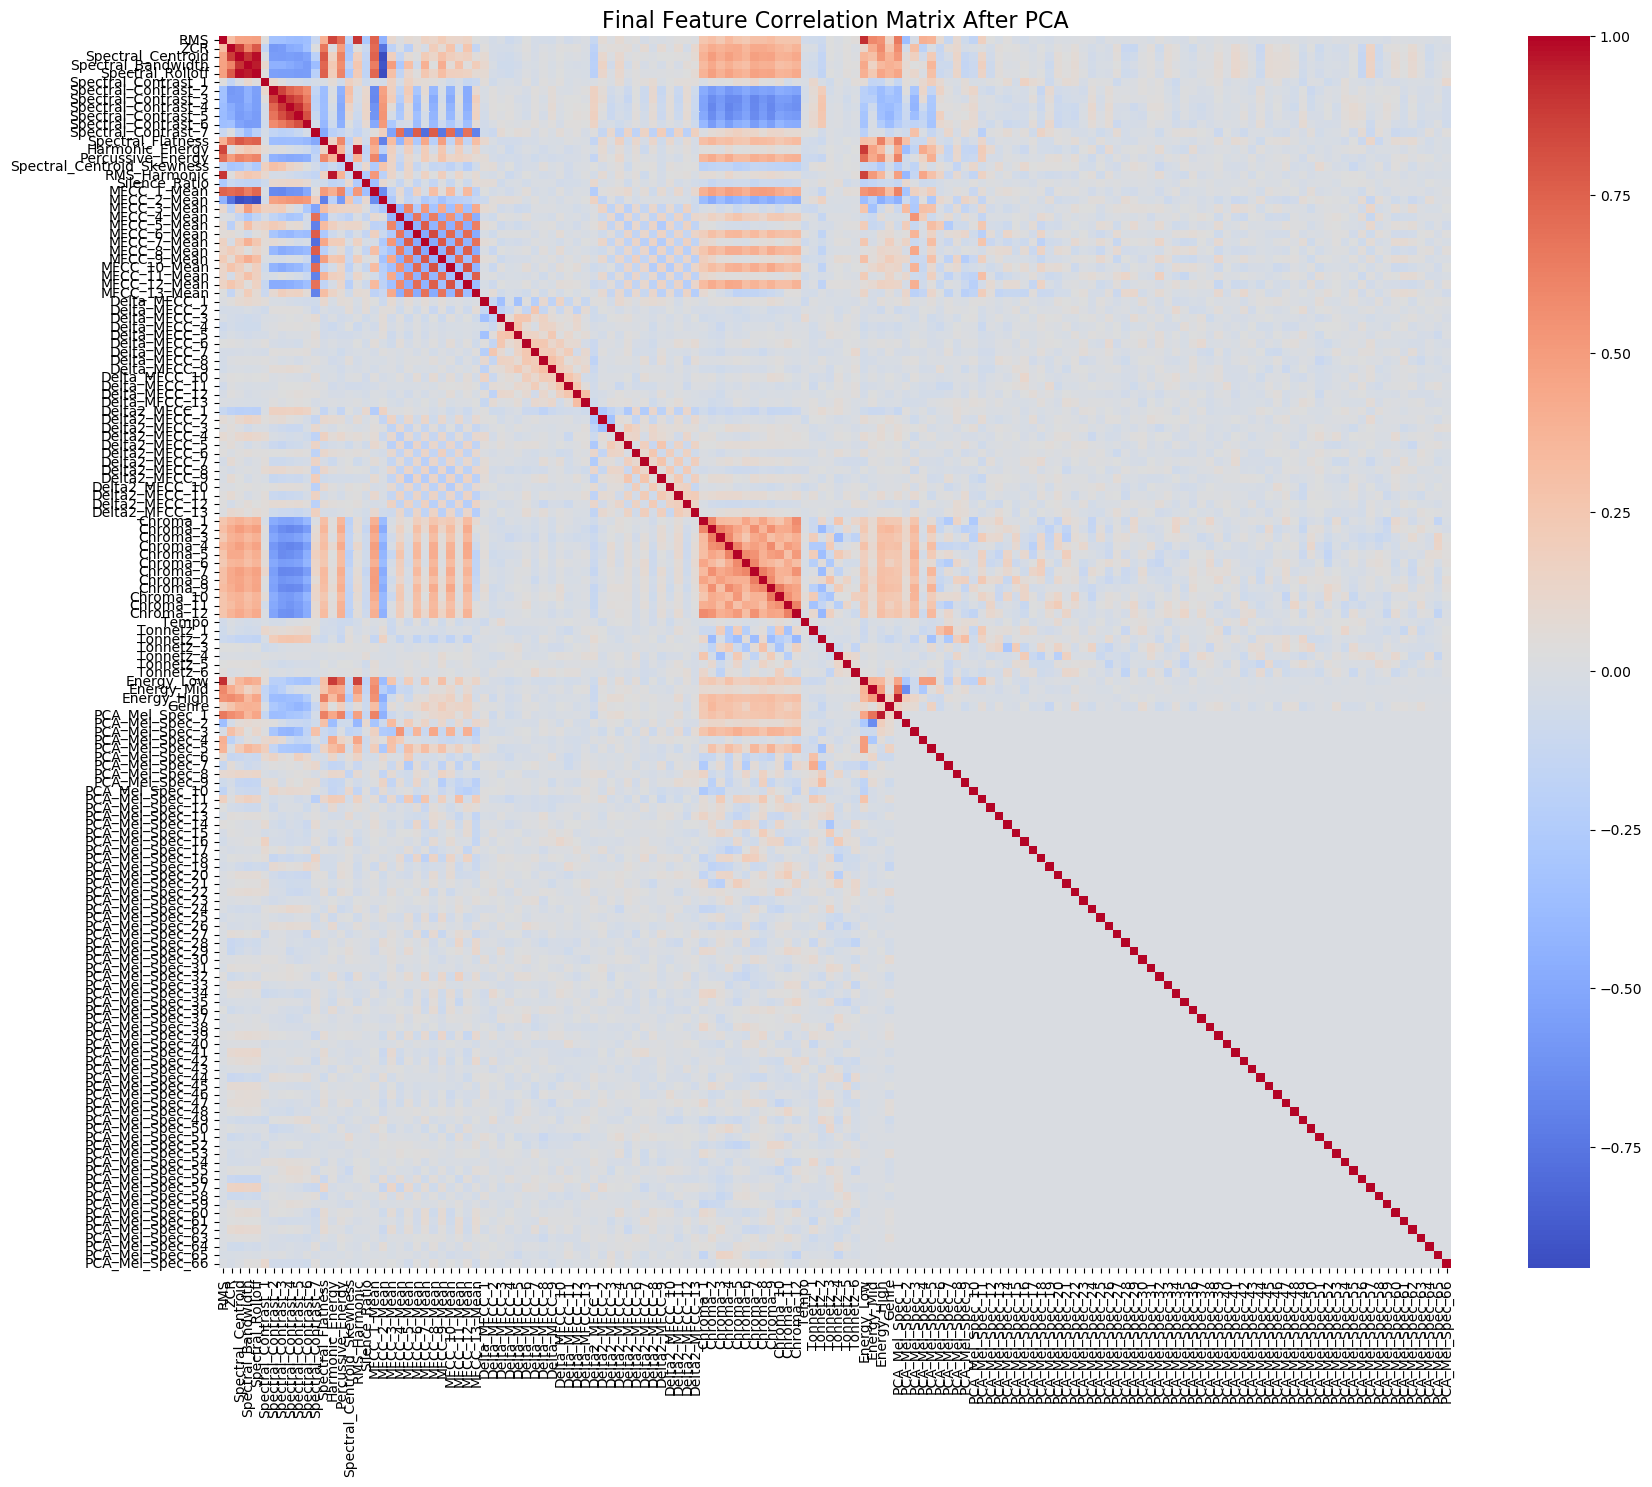

([('RMS', 'Energy_Low'),
  ('Spectral_Centroid', 'Spectral_Bandwidth'),
  ('Spectral_Centroid', 'Spectral_Rolloff'),
  ('Spectral_Centroid', 'MFCC_2_Mean'),
  ('Spectral_Bandwidth', 'Spectral_Centroid'),
  ('Spectral_Bandwidth', 'Spectral_Rolloff'),
  ('Spectral_Rolloff', 'Spectral_Centroid'),
  ('Spectral_Rolloff', 'Spectral_Bandwidth'),
  ('Spectral_Rolloff', 'MFCC_2_Mean'),
  ('Spectral_Contrast_4', 'Spectral_Contrast_5'),
  ('Spectral_Contrast_5', 'Spectral_Contrast_4'),
  ('Harmonic_Energy', 'RMS_Harmonic'),
  ('RMS_Harmonic', 'Harmonic_Energy'),
  ('MFCC_2_Mean', 'Spectral_Centroid'),
  ('MFCC_2_Mean', 'Spectral_Rolloff'),
  ('Energy_Low', 'RMS'),
  ('Energy_High', 'PCA_Mel_Spec_1'),
  ('PCA_Mel_Spec_1', 'Energy_High')],
 18)

In [6]:
# Recompute the correlation matrix for the final dataset (excluding the 'Genre' column)
correlation_matrix_final = df_final.iloc[:, :-1].corr()

# Visualize the updated correlation matrix for confirmation
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix_final, cmap='coolwarm', cbar=True, square=True, annot=False, 
            xticklabels=correlation_matrix_final.columns, yticklabels=correlation_matrix_final.columns)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Final Feature Correlation Matrix After PCA', fontsize=16)
plt.show()

# Identify highly correlated features (correlation > 0.9)
high_corr_pairs = [(i, j) for i in correlation_matrix_final.columns for j in correlation_matrix_final.columns 
                   if i != j and abs(correlation_matrix_final.loc[i, j]) > 0.9]
# Display summary of highly correlated features
high_corr_pairs, len(high_corr_pairs)  # Display the first 10 pairs and total count of highly correlated features


In [8]:
# save df_final to an Excel file
df_final.to_excel('../_03_data_gtzan_features_labels_pca.xlsx', index=False)


In [8]:
summary_stats_path = '../_04_summary_statistics_gtzan_features_labels.xlsx'     # Path to the summary statistics file
summary_stats_df = sheet_data.describe()                                           # Get the summary statistics of the data
summary_stats_df.to_excel(summary_stats_path)                                      # Save the summary statistics to an Excel file
summary_stats_excel = pd.ExcelFile(summary_stats_path)                                         # Load the Excel file
summary_stats_excel.sheet_names                                                                # See all sheet names
summary_stats_sheet1_df = summary_stats_excel.parse('Sheet1')                                                # Load the data from the first sheet
summary_stats_sheet1_df.set_index('Unnamed: 0', inplace=True)  # Set the first column as the index
num_rows = summary_stats_sheet1_df.shape[0]                                                   # Get the number of rows in the data
summary_stats_sheet1_df.head(num_rows)                                                        # Display all rows


,RMS,ZCR,Spectral_Centroid,Spectral_Bandwidth,Spectral_Rolloff,Spectral_Contrast_1,Spectral_Contrast_2,Spectral_Contrast_3,Spectral_Contrast_4,Spectral_Contrast_5,...,Mel_Spec_123,Mel_Spec_124,Mel_Spec_125,Mel_Spec_126,Mel_Spec_127,Mel_Spec_128,Energy_Low,Energy_Mid,Energy_High,Genre
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.161560,0.103622,2202.096020,2242.955705,4572.221942,21.582560,16.297717,19.618642,19.319273,19.293937,...,6.674674e-02,6.400790e-02,6.197083e-02,6.095888e-02,5.969335e-02,6.121917e-02,20.406776,1.974216,0.275636,4.500000
std,0.054685,0.041822,715.912318,526.169748,1574.656423,3.963536,2.267942,2.777187,2.760823,2.555691,...,2.496622e-01,2.664910e-01,2.517142e-01,3.069990e-01,3.013755e-01,3.879763e-01,13.745060,1.691073,0.408605,2.873719
min,0.040790,0.021697,570.751656,901.383563,749.698534,12.834756,10.635479,11.629702,13.940097,14.029853,...,4.093056e-07,1.301285e-07,5.307555e-08,2.920832e-08,1.897411e-08,1.315659e-08,2.160156,0.027882,0.000093,0.000000
25%,0.122724,0.070244,1627.924292,1907.425928,3380.359000,18.751159,14.683895,17.649018,17.442471,17.542816,...,4.691513e-04,1.460305e-04,3.020779e-05,3.816286e-06,4.922758e-07,1.650919e-07,10.549572,0.813172,0.057732,2.000000
50%,0.152158,0.099552,2212.359540,2223.835942,4660.751902,20.855844,15.884700,19.130724,18.817402,18.776842,...,2.524294e-03,8.045206e-04,2.370542e-04,6.825099e-05,5.463815e-05,4.688233e-05,16.409314,1.520142,0.170560,4.500000
75%,0.193524,0.131944,2691.319263,2578.535843,5533.870830,24.079221,17.623404,21.230843,20.743261,20.761390,...,4.267151e-02,4.050143e-02,3.838672e-02,3.269844e-02,3.056503e-02,2.750562e-02,26.569999,2.594677,0.357650,7.000000
max,0.397734,0.274631,4435.727333,3509.656096,8677.730976,37.028675,24.984113,29.745984,30.059467,31.928804,...,6.208045e+00,7.025799e+00,6.276015e+00,8.698340e+00,8.504979e+00,1.146227e+01,105.366737,12.487714,9.192969,9.000000



### Analysis of Descriptive Summary Plot

1. **Outliers**:
    - The presence of outliers can be inferred from the large range (min to max) in some features. The large range is definitely obvious in the plot for the spectral features. It is crucial to handle outliers before applying scaling techniques because: Outliers can skew the mean (for standardization) or the range (for normalization), leading to incorrect scaling, therefore affecting model performance. We can handle outliers by removal or capping.
    The plot suggest that some outliers might exist but we cannot confirm the existence of outliers just based on visual inspection: we need to apply techniques like Z-score and IQR (Inter Quartile Range) for outliers detection:
    https://medium.com/@ayeshasidhikha188/unveiling-outliers-exploring-z-score-and-iqr-methods-for-boxplots-67b0f3086720
    
    
2. **Feature Scaling**:
    - Features like `Spectral_Rolloff`, `Spectral_Centroid`, and `Spectral_Bandwidth` have significantly higher values compared to others. This indicates the need for feature scaling (normalization or standardization) to ensure that these features do not dominate the model training process. The spectral features show high variability (variance) which is confirmed by their high standard deviation. These features might dominate distance-based models like (k-NN, SVM) or gradient-based models if not scaled properly. Algorithms like SVM, k-NN, and neural networks are sensitive to the scale of input features. Ensuring that all features are on a similar scale can lead to better model performance and faster convergence during training.
    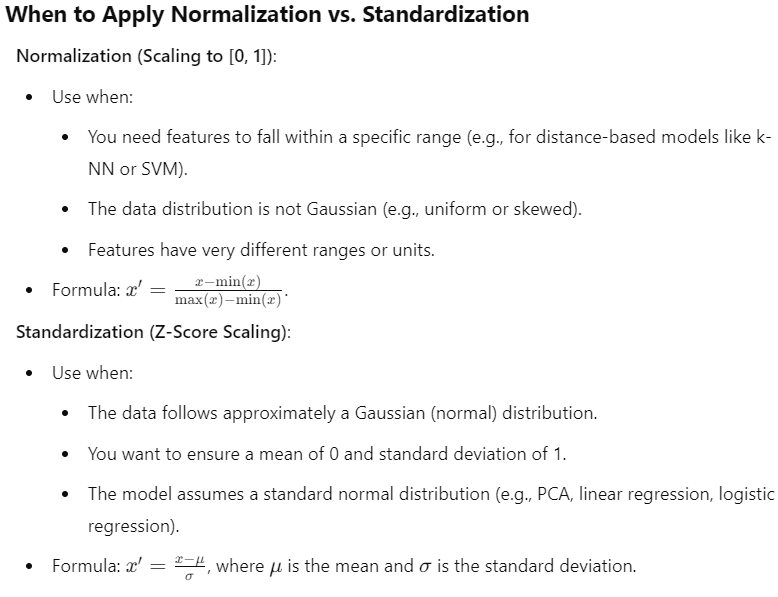


3. **Feature Importance - Random Forest**:
    - Consistent Features
    - Examples: Chroma features (e.g., Chroma_1 to Chroma_12).
    - Insights: These features have relatively small ranges and low standard deviations, indicating consistency across samples.
    - Implications: Consistent features might provide stable information for classification tasks, but low variability could    reduce their discriminative power.
    - Action: use Random Forest first to select the top features, then apply dimensionality reduction techniques (PCA, tsne) on the selected features, if dimension is of concern
